In [2]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [3]:
path.ls()

(#23) [Path('/root/.fastai/data/ml-100k/u4.base'),Path('/root/.fastai/data/ml-100k/u4.test'),Path('/root/.fastai/data/ml-100k/u.data'),Path('/root/.fastai/data/ml-100k/allbut.pl'),Path('/root/.fastai/data/ml-100k/mku.sh'),Path('/root/.fastai/data/ml-100k/ua.test'),Path('/root/.fastai/data/ml-100k/ua.base'),Path('/root/.fastai/data/ml-100k/u.item'),Path('/root/.fastai/data/ml-100k/u2.test'),Path('/root/.fastai/data/ml-100k/u3.test')...]

In [4]:
device = 'cpu' 
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'

device = torch.device(device)
device

device(type='cpu')

In [5]:
ratings = pd.read_csv(path/'u.data', delimiter='\t',header=None,
                      names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


**u.item**
Information about the items (movies); this is a tab separated list of
```
movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy |Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western |
```
The last 19 fields are the genres, a 1 indicates the movie is of that genre, a 0 indicates it is not; movies can be in several genres at once.

In [6]:
movies= pd.read_csv(path/'u.item',  delimiter='|',encoding='latin-1',
                    usecols=(0,1),names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [7]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [8]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64, device=device)
dls.show_batch()

,user,title,rating
0,134,"Saint, The (1997)",5
1,366,From Dusk Till Dawn (1996),5
2,655,Babe (1995),3
3,942,Lone Star (1996),4
4,850,Winnie the Pooh and the Blustery Day (1968),5
5,660,"Hunt for Red October, The (1990)",2
6,593,"Princess Bride, The (1987)",5
7,686,"Endless Summer 2, The (1994)",1
8,201,Groundhog Day (1993),3
9,399,Highlander (1986),2


In [9]:
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [10]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_users,n_movies

(944, 1665)

In [11]:
n_factors = 5

In [12]:
user_factors =  torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [13]:
one_hot_3 = one_hot(3, n_users).float() # genrate a tensor of shape : [944]
user_factors.t() @one_hot_3

tensor([ 0.2158, -1.8803, -1.2101,  1.7352,  0.3623])

In [14]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies =  self.movie_factors(x[:,1])
        #print(users.shape, movies.shape) # batch_size * n_factors
        return (users * movies).sum(dim=1)

In [15]:
model = DotProduct(n_users, n_movies, 50)
x, y = dls.one_batch()

In [16]:
model.forward(x).shape

torch.Size([64])

In [18]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-5)

epoch,train_loss,valid_loss,time
0,13.743404,13.724434,00:20
1,13.606895,13.679506,00:19
2,13.410686,13.566105,00:19
3,13.483063,13.482481,00:19
4,13.522548,13.467183,00:19


The loss is very bad, as the value of y can be anything. We are apllying a squish function to put in range of 0-5.5 using sigmod_range. It takes in a value and applay sigmoidon  it  and scales the result.

In [17]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range  = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies =  self.movie_factors(x[:,1])
        #print(users.shape, movies.shape) # batch_size * n_factors
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [18]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model=model, loss_func=MSELossFlat())

In [19]:
learn.fit_one_cycle(5, 5e-5)

epoch,train_loss,valid_loss,time
0,1.923123,1.862808,00:15
1,1.867270,1.862527,00:13
2,1.911231,1.860921,00:13
3,1.887783,1.858943,00:13
4,1.871681,1.858507,00:14


In [22]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)

        self.movie_bias = Embedding(n_movies, 1)
        self.user_bias = Embedding(n_users, 1)

        self.y_range  = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies =  self.movie_factors(x[:,1])

        res = (users * movies).sum(dim=1, keepdim=True)
        #print(res.shape)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        
        return sigmoid_range(res, *self.y_range)

In [23]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model=model, loss_func=MSELossFlat())

In [24]:
learn.fit_one_cycle(5, 5e-5)

epoch,train_loss,valid_loss,time
0,1.913728,1.839827,00:15
1,1.813946,1.784840,00:14
2,1.742355,1.742815,00:13
3,1.743469,1.722560,00:14
4,1.724686,1.719148,00:13


In [25]:
user_bias = Embedding(n_users, 1)
user_bias(x[:,0]).shape

torch.Size([64, 1])

In [28]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model=model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.2)


epoch,train_loss,valid_loss,time


In [29]:
class T(Module):
    def __init__(self):
        self.a = torch.ones(3)
L(T().parameters())

(#0) []

In [30]:
class T(Module):
    def __init__(self):
        self.a = nn.Parameter(torch.ones(3))
L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [31]:
class T(Module):
    def __init__(self):
        self.a = nn.Linear(1, 3, bias=True)
t = T()
L(t.parameters())

(#2) [Parameter containing:
tensor([[ 0.5727],
        [-0.9480],
        [ 0.9316]], requires_grad=True),Parameter containing:
tensor([-0.7718, -0.4101, -0.1732], requires_grad=True)]

In [32]:
type(t.a.weight), type(t.a.bias)

(torch.nn.parameter.Parameter, torch.nn.parameter.Parameter)

In [33]:
torch.zeros(1,2).normal_(0, 0.01)

tensor([[-0.0045,  0.0033]])

In [19]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [20]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,  5.5)):
        self.user_factors =  create_params((n_users, n_factors))
        self.movie_factors = create_params((n_movies, n_factors))

        self.movie_bias = create_params((n_movies,1))
        self.user_bias = create_params((n_users, 1))

        self.y_range = y_range
    
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        
        res = (users * movies).sum(dim=1, keepdim=True)
        #print(res.shape)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        #print(res.shape)

        return sigmoid_range(res, *self.y_range)


In [21]:
model = DotProduct(n_users, n_movies, 5)
model.forward(x).shape

torch.Size([64, 1])

In [26]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.866763,0.943156,00:26
1,0.661610,0.905504,00:22
2,0.540367,0.881332,00:56
3,0.461894,0.862465,00:28
4,0.431477,0.858973,00:30


In [28]:
movie_bias = learn.model.movie_bias.squeeze()
movie_bias.shape, learn.model.movie_bias.shape

(torch.Size([1665]), torch.Size([1665, 1]))

In [37]:
t = Tensor([2,3,1,4,1])
t, t.argsort(), t.argsort(descending=True)

(tensor([2., 3., 1., 4., 1.]),
 tensor([2, 4, 0, 1, 3]),
 tensor([3, 1, 0, 2, 4]))

In [38]:
idxs = movie_bias.argsort()[:5] # find the index of last 5 elements in ascending order or lower bias 
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [39]:
[dls.classes["title"][i] for i in idxs]

['Cable Guy, The (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Striptease (1996)',
 'Tales from the Hood (1995)',
 'Children of the Corn: The Gathering (1996)']

In [41]:
idxs = movie_bias.argsort(descending=True)[:5] # find the index of last 5 elements in descending order or higer bias 
[dls.classes["title"][i] for i in idxs]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Star Wars (1977)',
 "Schindler's List (1993)",
 'Close Shave, A (1995)']

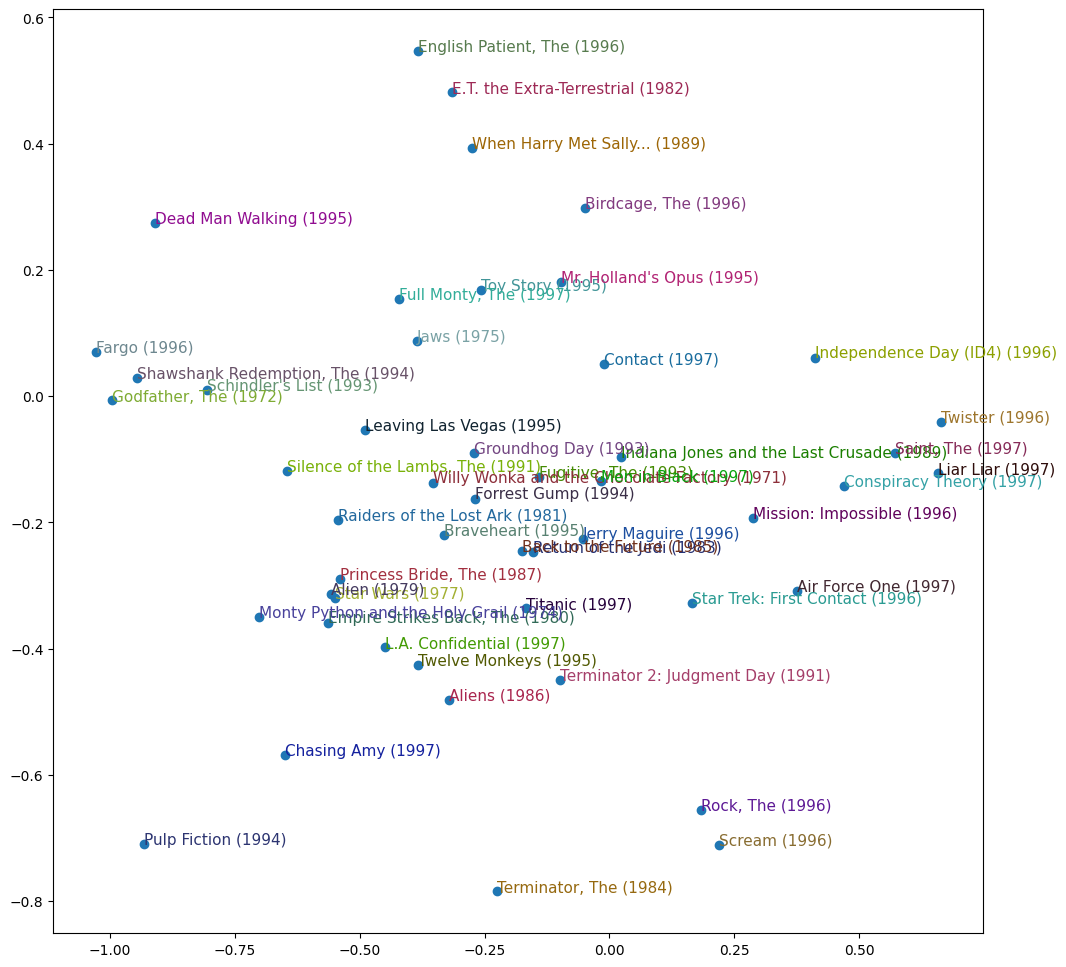

In [46]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Measuring Embedding distance

In [49]:
movie_embedding = model.movie_factors
movie_embedding.shape

torch.Size([1665, 50])

In [63]:
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)'] #extract the index of the movie
mov_embd = movie_embedding[idx][None]
idx, mov_embd.shape

(1330, torch.Size([1, 50]))

In [64]:
cos = nn.CosineSimilarity(dim=1)
dist = cos(movie_embedding, mov_embd)

In [65]:
dist[idx] # checking if the distance from the same idx is 1

tensor(1., grad_fn=<SelectBackward0>)

In [66]:
dls.classes['title'][dist.argsort(descending=True)[:3]]

(#3) ['Silence of the Lambs, The (1991)','Dial M for Murder (1954)',"One Flew Over the Cuckoo's Nest (1975)"]

Using Deep Learning

In [72]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [84]:
class CollabNN(Module):
    def __init__(self, user_sz, movie_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.movie_factors = Embedding(*movie_sz)

        self.layers = nn.Sequential(
            nn.Linear(user_sz[1] + movie_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1)
        )

        self.y_range = y_range
    
    def forward(self, x):
        embds = self.user_factors(x[:,0]), self.movie_factors(x[:,1])

        x = self.layers(torch.cat(embds, dim=1))
        return sigmoid_range(x, *self.y_range)
    

In [79]:
x =  torch.randn((10,10)), torch.randn((10,20))
torch.cat(x,dim=1).shape

torch.Size([10, 30])

In [85]:
model = CollabNN(*embs)

In [87]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.887967,0.933539,00:16
1,0.818988,0.907695,00:15
2,0.793484,0.886779,00:15
3,0.751754,0.880998,00:15
4,0.739559,0.873698,00:15


In [88]:
MSELossFlat??

Signature:
MSELossFlat(
    *args,
    axis: 'int' = -1,
    floatify: 'bool' = True,
    reduction='mean',
)
Source:   
@use_kwargs_dict(reduction='mean')
def MSELossFlat(
    *args, 
    axis:int=-1, # Class axis
    floatify:bool=True, # Convert `targ` to `float`
    **kwargs
):
    "Same as `nn.MSELoss`, but flattens input and target."
    return BaseLoss(nn.MSELoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
File:      /home/sagar/git/fastai/fastai/losses.py
Type:      function

In [90]:
delegates??

Signature: delegates(to: function = None, keep=False, but: list = None)
Source:   
def delegates(to:FunctionType=None, # Delegatee
              keep=False, # Keep `kwargs` in decorated function?
              but:list=None): # Exclude these parameters from signature
    "Decorator: replace `**kwargs` in signature with params from `to`"
    if but is None: but = []
    def _f(f):
        if to is None: to_f,from_f = f.__base__.__init__,f.__init__
        else:          to_f,from_f = to.__init__ if isinstance(to,type) else to,f
        from_f = getattr(from_f,'__func__',from_f)
        to_f = getattr(to_f,'__func__',to_f)
        if hasattr(from_f,'__delwrap__'): return f
        sig = inspect.signature(from_f)
        sigd = dict(sig.parameters)
        k = sigd.pop('kwargs')
        s2 = {k:v.replace(kind=inspect.Parameter.KEYWORD_ONLY) for k,v in inspect.signature(to_f).parameters.items()
              if v.default != inspect.Parameter.empty and k not in sigd and k not in but}
      